# MSE with time dependent transcription rate

In [1]:
%load_ext autoreload
%autoreload 2

## Library imports

In [2]:
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from velovi import preprocess_data, VELOVI

sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [3]:
scvi.settings.dl_pin_memory_gpu_training = False

In [4]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [5]:
SAVE_FIGURES = True

## Function definitions

In [6]:
def fit_velovi(bdata, time_dep_transcription_rate=False):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata, time_dep_transcription_rate=time_dep_transcription_rate)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    if vae.module.time_dep_transcription_rate:
        bdata.var["fit_alpha_1"] = vae.get_rates()["alpha_1"] / scaling
        bdata.var["fit_lambda_alpha"] = vae.get_rates()["lambda_alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [7]:
def get_fit_velovi(bdata, model):
    return model.get_expression_fit(n_samples=20)

In [8]:
def get_alpha(t, t_switch, alpha, alpha_1, lambda_alpha):
    if isinstance(t_switch, pd.Series):
        t_switch = t_switch.values
    if isinstance(alpha, pd.Series):
        alpha = alpha.values
    if isinstance(alpha_1, pd.Series):
        alpha_1 = alpha_1.values
    if isinstance(lambda_alpha, pd.Series):
        lambda_alpha = lambda_alpha.values
    
    alpha = alpha_1 - (alpha_1 - alpha) * np.exp(-lambda_alpha * t)
    alpha[t >= t_switch] = 0

    return alpha

In [9]:
def get_state(t, alpha_0, alpha_1, lambda_alpha, beta, gamma, initial_state, t0=0):
    u0 = initial_state[0]
    s0 = initial_state[1]

    u = (
        u0 * np.exp(-beta * t)
        + alpha_1 / beta * (1 - np.exp(-beta * t))
        - (alpha_1 - alpha_0) / (beta - lambda_alpha) * np.exp(-lambda_alpha * t0) * (np.exp(-lambda_alpha * t) - np.exp(-beta * t))
    )

    s = (
        s0 * np.exp(-gamma * t)
        + alpha_1 / gamma * (1 - np.exp(-gamma * t))
        + (alpha_1  - beta * u0) / (gamma - beta) * (np.exp(-gamma * t) - np.exp(-beta * t))
        - beta * (alpha_1 - alpha_0) / (beta - lambda_alpha) / (gamma - lambda_alpha) * np.exp(-lambda_alpha * t0) * (np.exp(-lambda_alpha * t) - np.exp(-gamma * t))
        + beta * (alpha_1 - alpha_0) / (beta - lambda_alpha) / (gamma - beta) * np.exp(-lambda_alpha * t0) * (np.exp(-beta * t) - np.exp(-gamma * t))
    )

    return u, s

In [10]:
def get_vars(adata, key="fit"):
    alpha_0 = (
        adata.var[f"{key}_alpha"].values if f"{key}_alpha" in adata.var.keys() else 1
    )
    alpha_1 = (
        adata.var[f"{key}_alpha_1"].values if f"{key}_alpha_1" in adata.var.keys() else 0
    )
    lambda_alpha = (
        adata.var[f"{key}_lambda_alpha"].values if f"{key}_lambda_alpha" in adata.var.keys() else 0
    )
    beta = adata.var[f"{key}_beta"].values if f"{key}_beta" in adata.var.keys() else 1
    gamma = adata.var[f"{key}_gamma"].values
    t_switch = adata.var[f"{key}_t_"].values
    
    return alpha_0, alpha_1, lambda_alpha, beta, gamma, t_switch

In [11]:
def compute_dynamics(adata, basis, key="true", sort=True):
    idx = adata.var_names.get_loc(basis) if isinstance(basis, str) else basis
    key = "fit" if f"{key}_gamma" not in adata.var_keys() else key
    alpha_0, alpha_1, lambda_alpha, beta, gamma, t_switch = get_vars(adata[:, basis], key=key)
    t = np.linspace(0, 20, 1000)  # adata.layers[f"{key}_t"][:, idx]
    if sort:
        t = np.sort(t)
    
    unspliced_induction, spliced_induction = get_state(
        t=t[t < t_switch],
        alpha_0=alpha_0,
        alpha_1=alpha_1,
        lambda_alpha=lambda_alpha,
        beta=beta,
        gamma=gamma,
        initial_state=[0, 0],
    )
    u0_switch, s0_switch = get_state(
        t=t_switch,
        alpha_0=alpha_0,
        alpha_1=alpha_1,
        lambda_alpha=lambda_alpha,
        beta=beta,
        gamma=gamma,
        initial_state=[0, 0],
    )
    
    unspliced_repression, spliced_repression = get_state(
        t=t[t >= t_switch] - t_switch,
        alpha_0=0,
        alpha_1=0,
        lambda_alpha=0,
        beta=beta,
        gamma=gamma,
        initial_state=[u0_switch, s0_switch],
    )
    
    unspliced = np.zeros(len(t))
    unspliced[t < t_switch] = unspliced_induction
    unspliced[t >= t_switch] = unspliced_repression
    spliced = np.zeros(len(t))
    spliced[t < t_switch] = spliced_induction
    spliced[t >= t_switch] = spliced_repression

    return unspliced, spliced

In [12]:
def get_rate_df(df_unspliced, df_spliced, gene):
    return pd.DataFrame(
        {
            f'unspliced': df_unspliced.loc[:, gene].values.squeeze(),
            f'spliced': df_spliced.loc[:, gene].values. squeeze(),
        }
    )

In [13]:
def plot_phase_portrait(adata, gene, df_const_rate, df_time_dep_rate, color, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    df = pd.DataFrame(
        {
            'unspliced': adata[:, gene].layers['Mu'].squeeze().copy(),
            'spliced': adata[:, gene].layers['Ms'].squeeze().copy(),
            'color': color
        }
    )

    sns.scatterplot(data=df, x='spliced', y='unspliced', c=color, s=25, ax=ax);

    unspliced = df_const_rate[f'unspliced']
    spliced = df_const_rate[f'spliced']
    ax.plot(spliced, unspliced, color="purple", linewidth=3)

    unspliced = df_time_dep_rate[f'unspliced']
    spliced = df_time_dep_rate[f'spliced']
    ax.plot(spliced, unspliced, color="purple", linestyle="--", linewidth=3)
    ax.axis('off')
    ax.set_title(gene)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'comparison' / f'{gene}_const_vs_time_dep.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

## Data loading

In [14]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

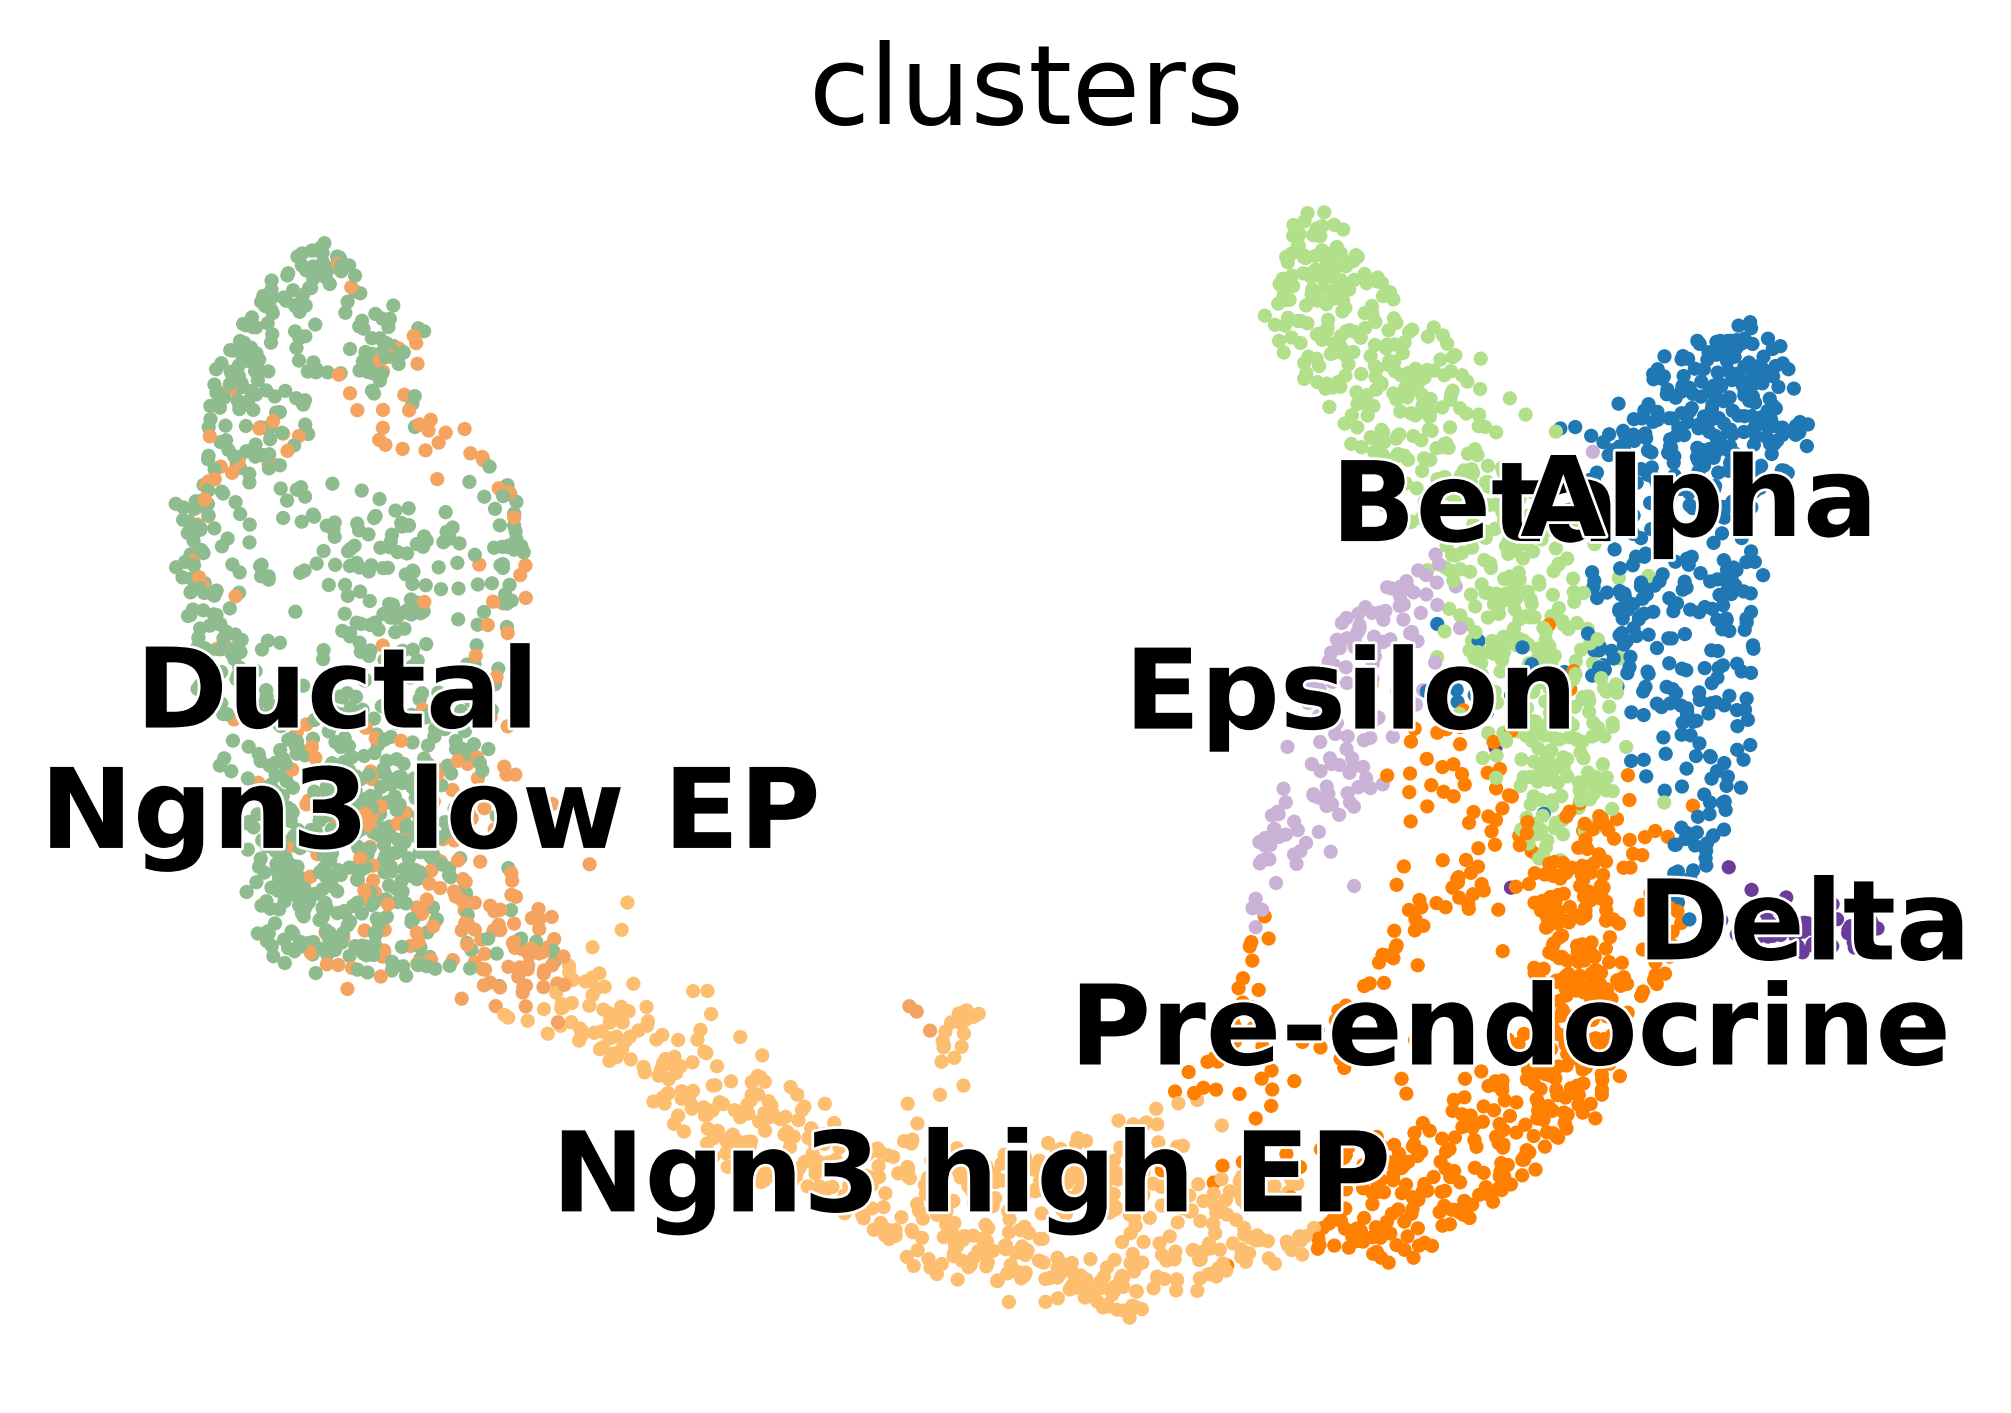

In [15]:
scv.pl.scatter(adata, basis='umap', c='clusters', dpi=200)

## Data preprocessing

In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata = preprocess_data(adata)

bdata = adata.copy()

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Model training

### Constant transcription rate

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:53<00:00,  4.42it/s, loss=-2.65e+03, v_num=1]


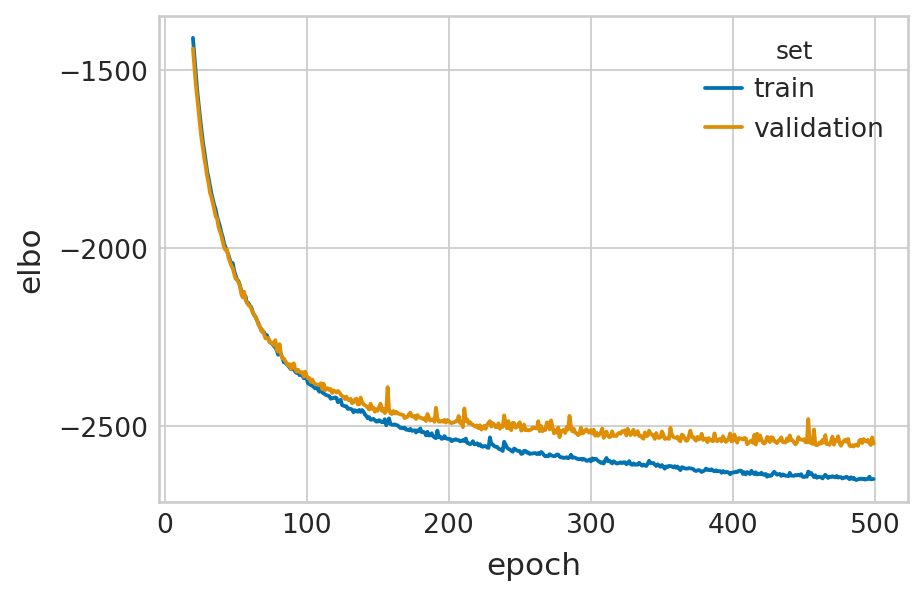

In [17]:
velovi_vae_const = fit_velovi(adata, time_dep_transcription_rate=False)

In [18]:
unspliced = []
spliced = []

for gene in tqdm(adata.var_names):
    _u, _s = compute_dynamics(adata, basis=gene, sort=True)
    unspliced.append(_u.tolist())
    spliced.append(_s.tolist())
    
df_unspliced_constant = pd.DataFrame(np.array(unspliced).T, columns=adata.var_names)
df_spliced_constant = pd.DataFrame(np.array(spliced).T, columns=adata.var_names)

100%|██████████| 1074/1074 [00:02<00:00, 437.97it/s]


### Time dependent transcription rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [02:23<00:00,  3.48it/s, loss=-2.89e+03, v_num=1]


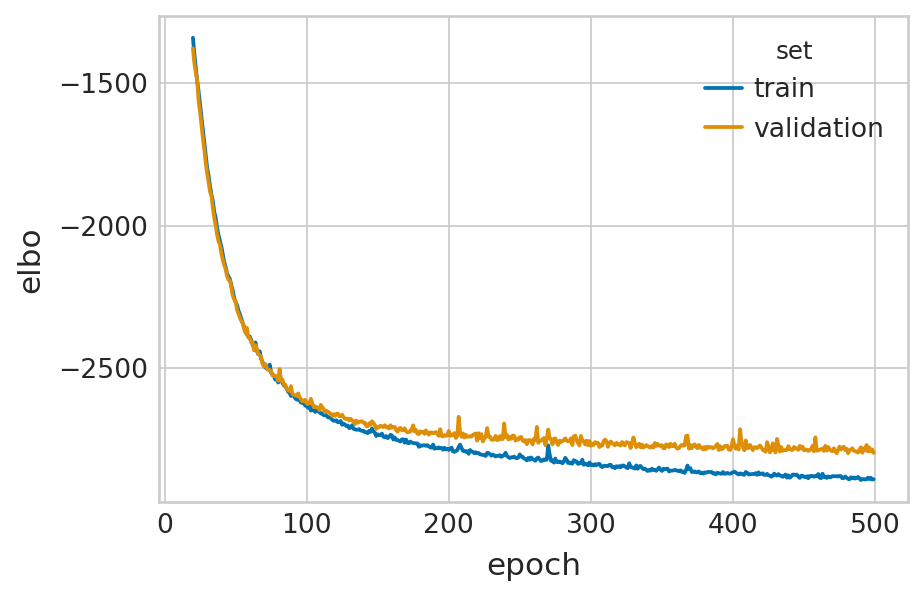

In [19]:
velovi_vae_time_dep = fit_velovi(bdata, time_dep_transcription_rate=True)

In [20]:
unspliced = []
spliced = []

for gene in tqdm(adata.var_names):
    _u, _s = compute_dynamics(bdata, basis=gene, sort=True)
    unspliced.append(_u.tolist())
    spliced.append(_s.tolist())
    
df_unspliced_time_dep = pd.DataFrame(np.array(unspliced).T, columns=adata.var_names)
df_spliced_time_dep = pd.DataFrame(np.array(spliced).T, columns=adata.var_names)

100%|██████████| 1074/1074 [00:02<00:00, 436.08it/s]


## Phase portraits

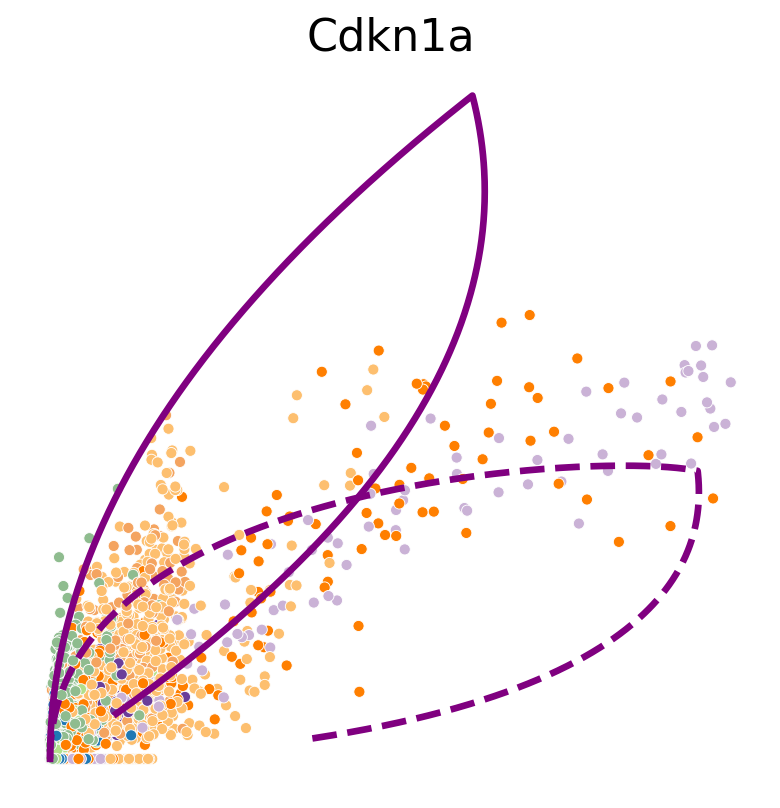

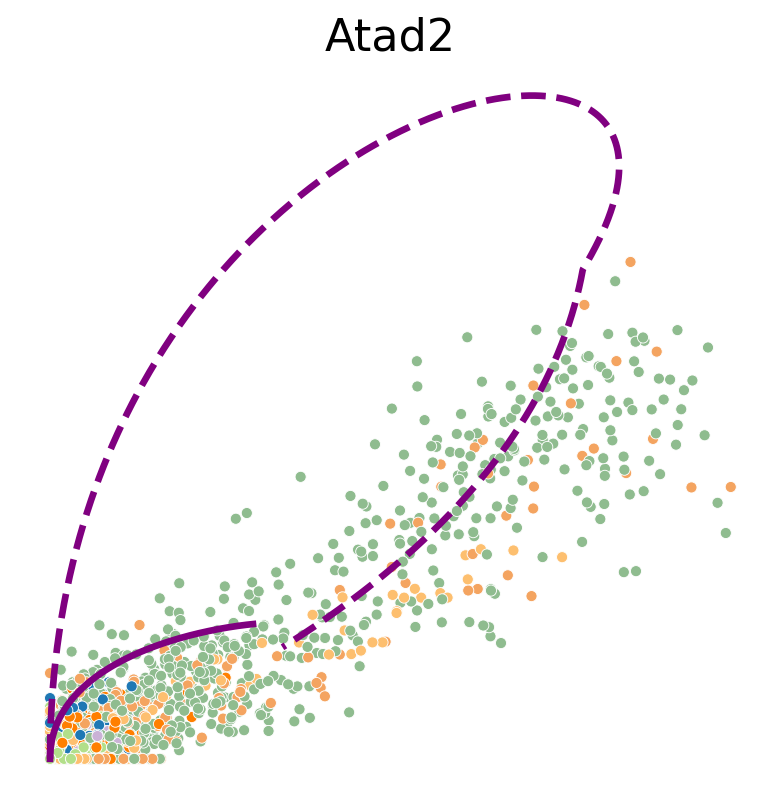

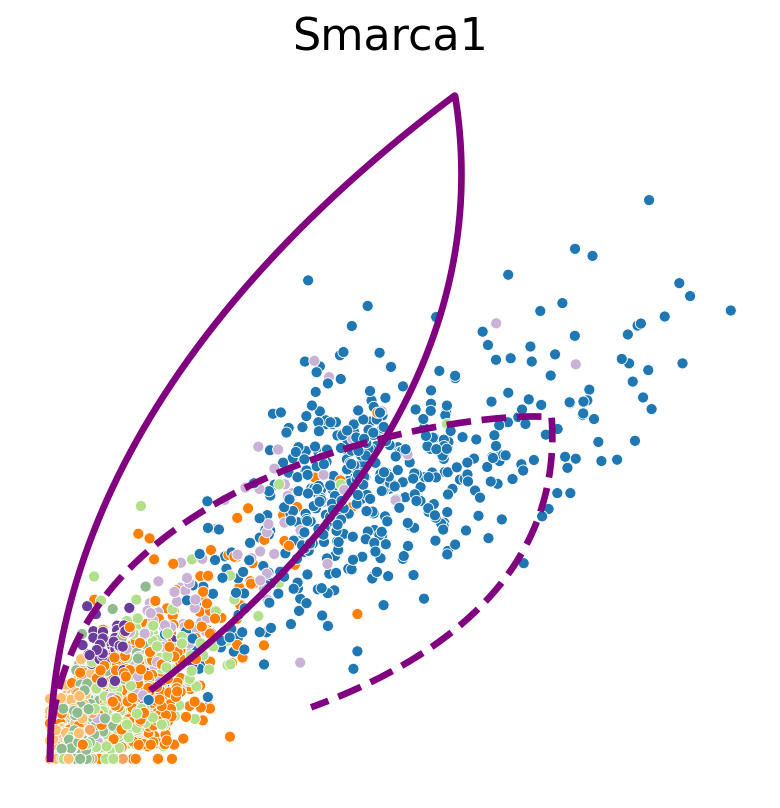

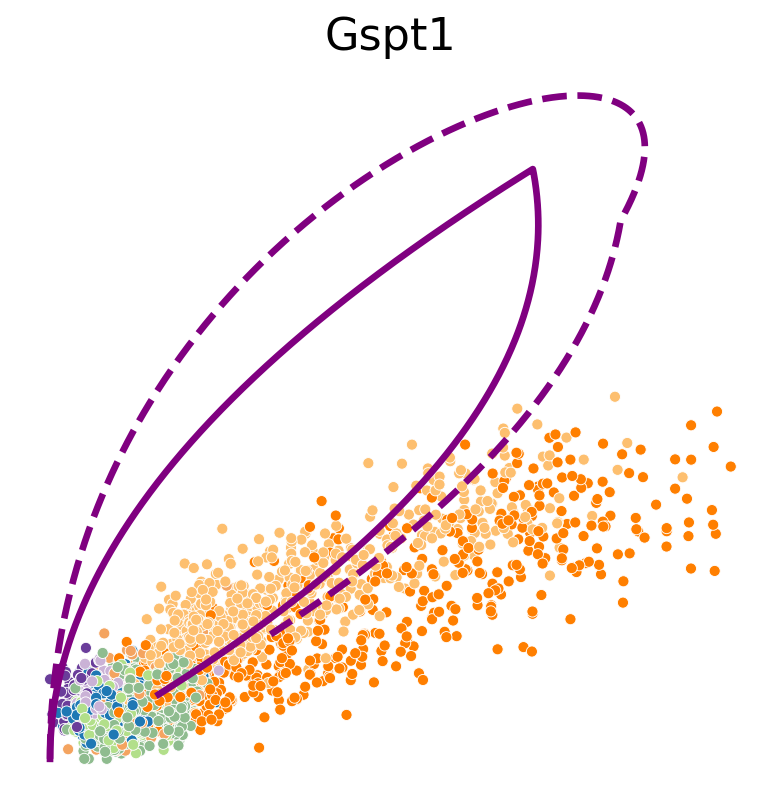

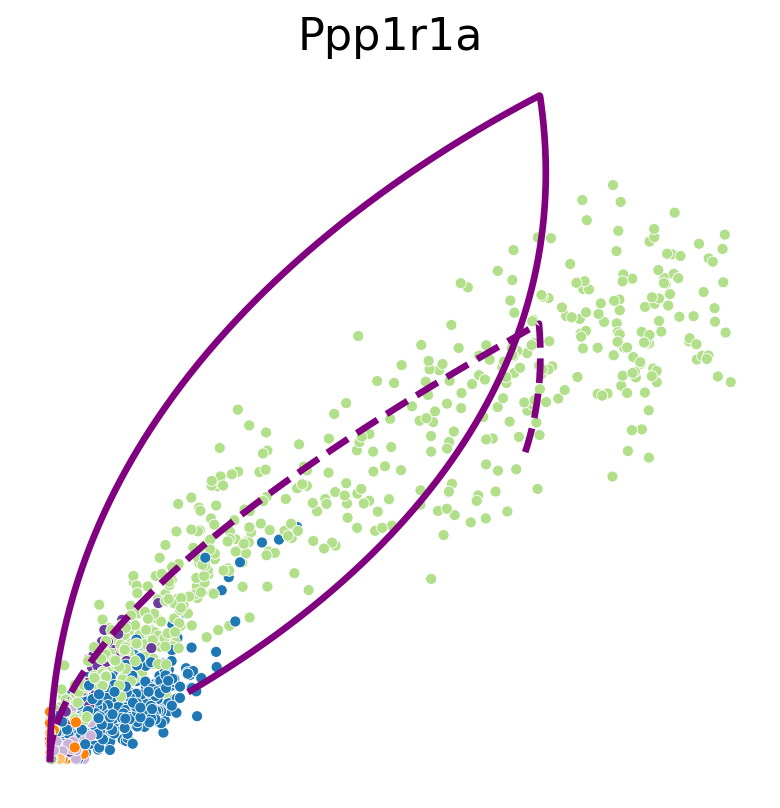

In [21]:
color = adata.obs['clusters'].replace(
    dict(
        zip(
            adata.obs['clusters'].cat.categories,
            adata.uns['clusters_colors']
        )
    )
).tolist()

for gene in ["Cdkn1a", "Atad2", "Smarca1", "Gspt1", "Ppp1r1a"]:
    df_const_rate = get_rate_df(
        df_unspliced=df_unspliced_constant,
        df_spliced=df_spliced_constant,
        gene=gene
    )

    df_time_dep_rate = get_rate_df(
        df_unspliced=df_unspliced_time_dep,
        df_spliced=df_spliced_time_dep,
        gene=gene
    )

    plot_phase_portrait(
        adata, gene=gene, df_const_rate=df_const_rate, df_time_dep_rate=df_time_dep_rate, color=color
    )

### Transcription rate

In [22]:
alpha = get_alpha(
    t=bdata.layers['fit_t'],
    t_switch=bdata.var['fit_t_'],
    alpha=bdata.var['fit_alpha'],
    alpha_1=bdata.var['fit_alpha_1'],
    lambda_alpha=bdata.var['fit_lambda_alpha']
)
alpha = pd.DataFrame(alpha, index=bdata.obs_names, columns=bdata.var_names)

In [23]:
df = bdata.var[['fit_alpha', 'fit_alpha_1', 'fit_lambda_alpha']]
df['fit_delta_alpha'] = df['fit_alpha'] - df['fit_alpha_1']

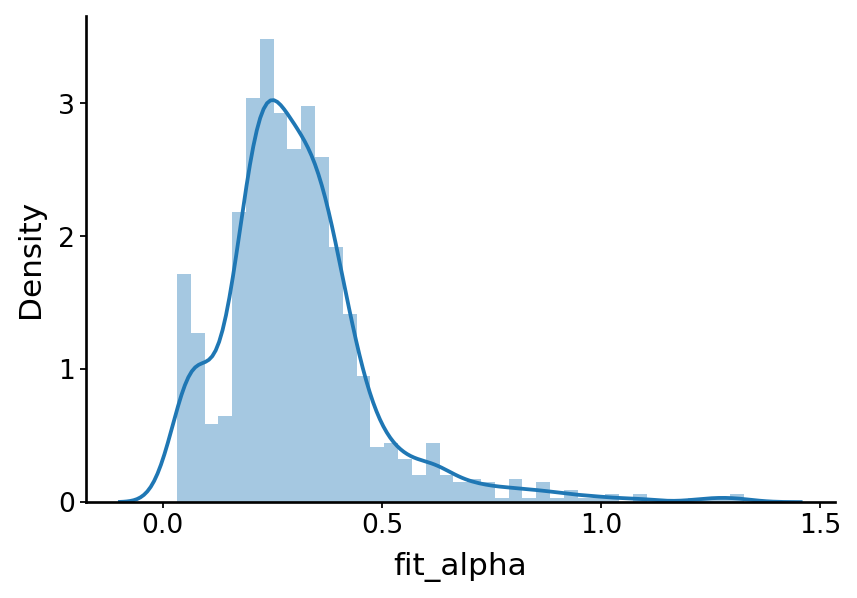

In [24]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.distplot(a=df['fit_alpha'], kde=True, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'alpha_0_distribution.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

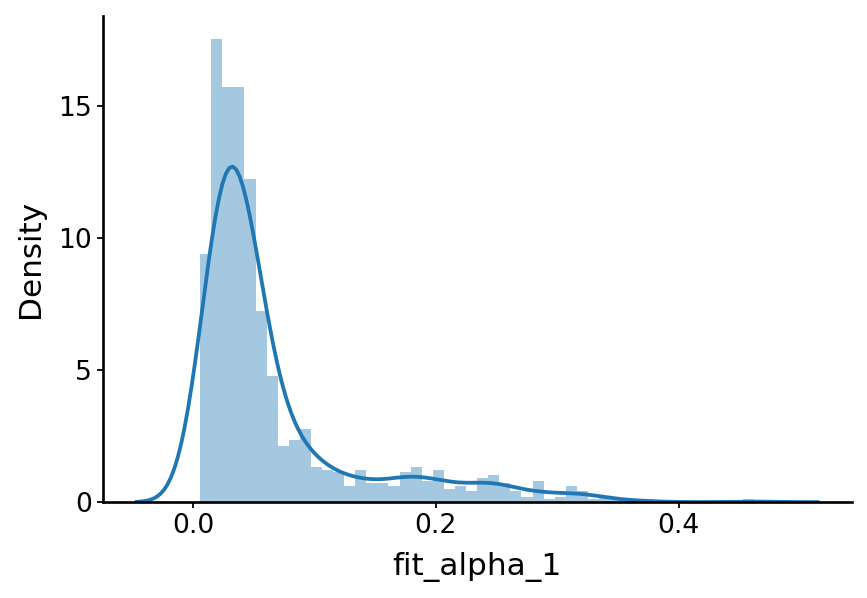

In [25]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.distplot(a=df['fit_alpha_1'], kde=True, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'alpha_1_distribution.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

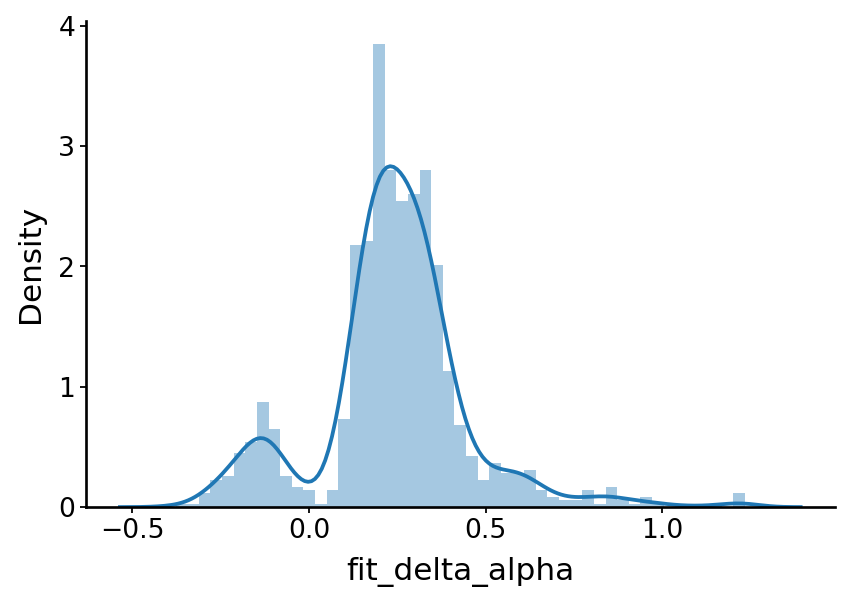

In [26]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.distplot(a=df['fit_delta_alpha'], kde=True, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'delta_alpha_distribution.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

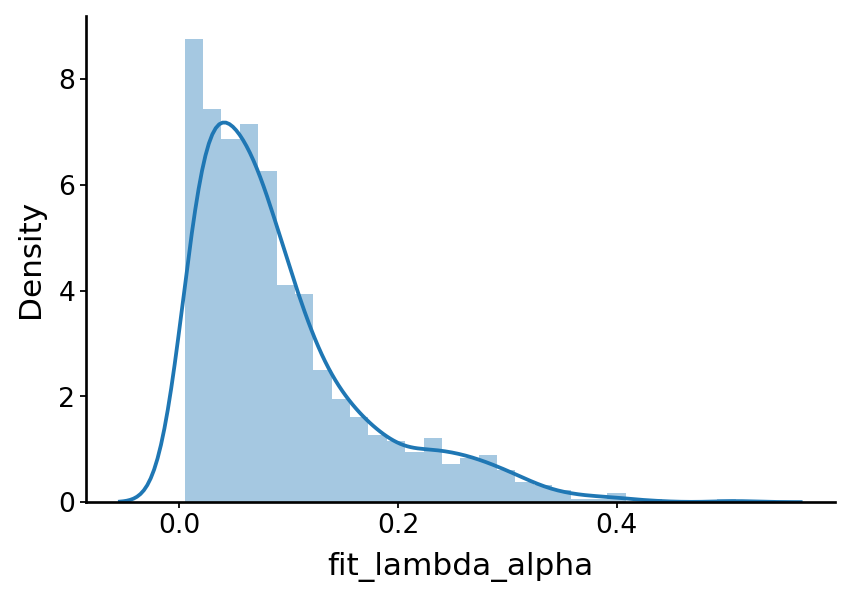

In [27]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.distplot(a=df['fit_lambda_alpha'], kde=True, ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'lambda_alpha_distribution.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

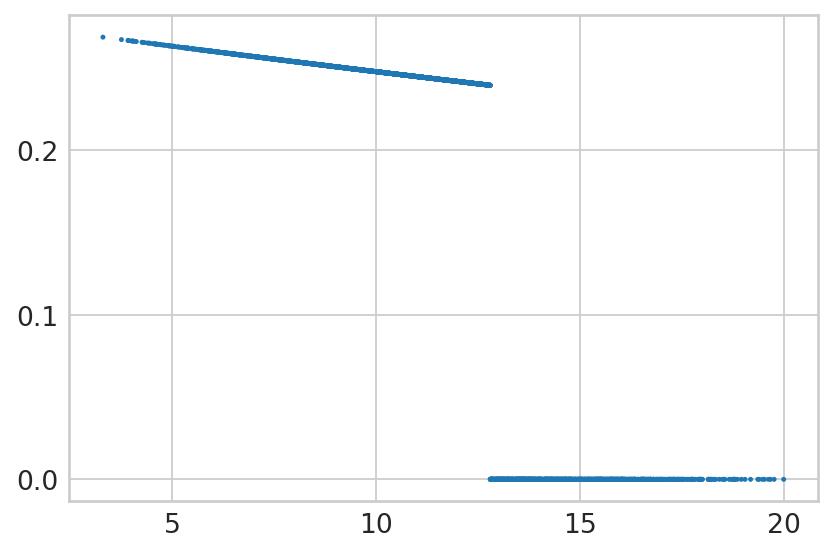

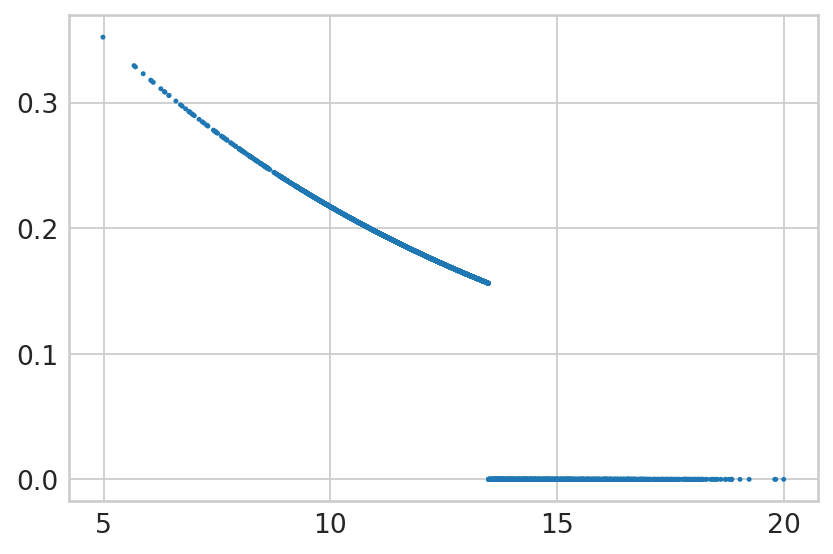

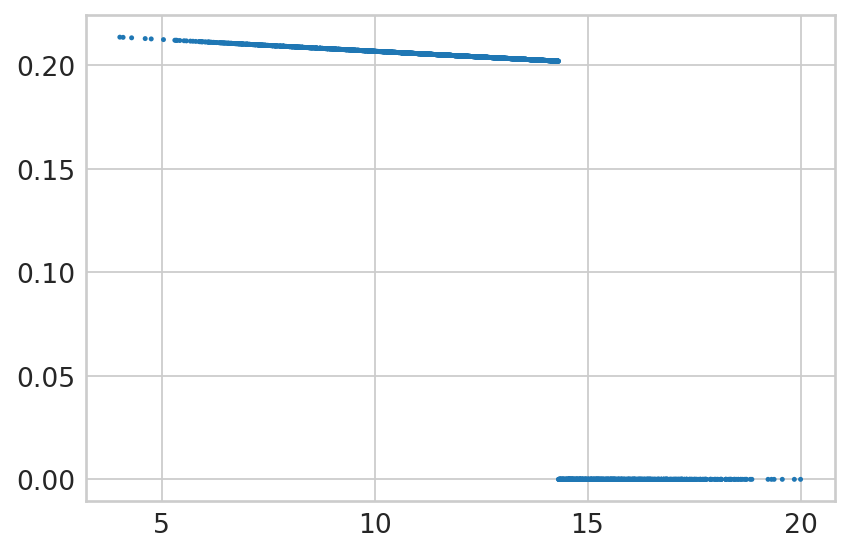

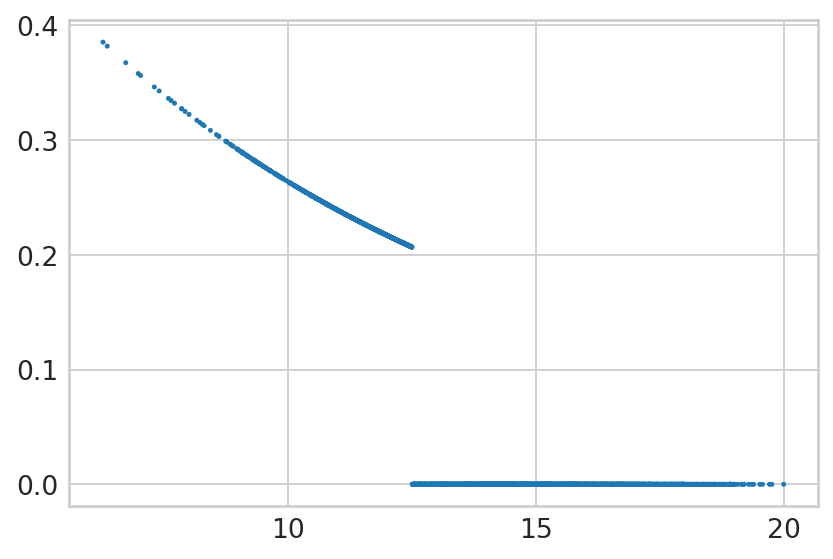

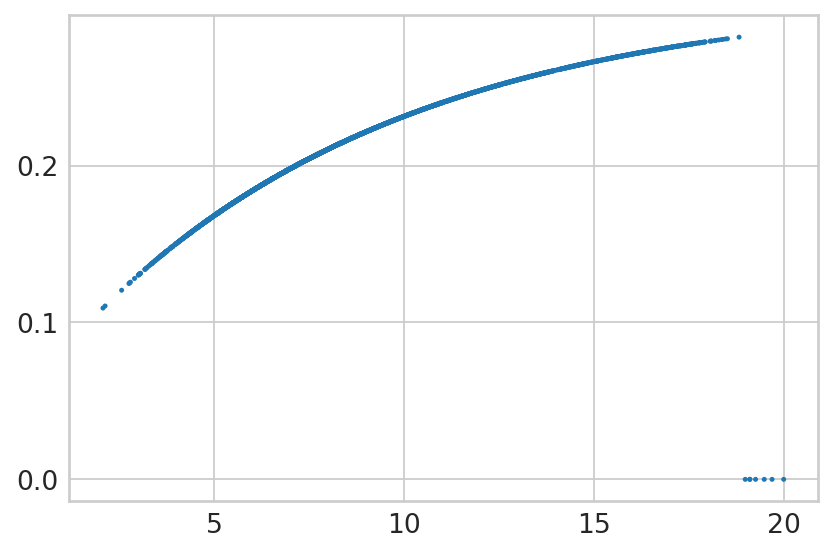

In [28]:
for gene in ["Cdkn1a", "Atad2", "Smarca1", "Gspt1", "Ppp1r1a"]:
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))

        sns.scatterplot(
            x=bdata[:, gene].layers['fit_t'].squeeze(),
            y=alpha[gene].values,
            edgecolor='none',
            legend=False,
            ax=ax,
            s=5,
        );
        ax.set_title(gene)

    if SAVE_FIGURES:
        ax.set_title('')
        fig.savefig(
            FIG_DIR / 'comparison' / f'{gene}_time_dep_alpha.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )